# Imports

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!unzip "/content/images.zip" -d "/content/images"

Archive:  /content/images.zip
replace /content/images/example.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Utilities

In [ ]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')

In [ ]:
def reorder(vertices):
    reordered = np.zeros_like(vertices, dtype=np.float32)
    add = vertices.sum(1)
    reordered[0] = vertices[np.argmin(add)]
    reordered[2] = vertices[np.argmax(add)]
    diff = np.diff(vertices, axis=1)
    reordered[1] = vertices[np.argmin(diff)]
    reordered[3] = vertices[np.argmax(diff)]
    return reordered

# Image

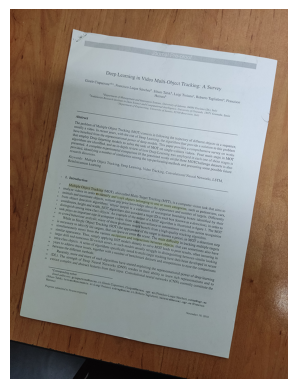

In [ ]:
image = cv2.imread('/content/images/example.jpg')
imshow(image)

# Process

Follow the hints in each section to implement the functions.

## Grayscale Transform

Use the `cv2.cvtColor` function with any color space you deem appropriate. The resulting image should have a single channel.

In [ ]:
def to_grayscale(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return grayscale_image

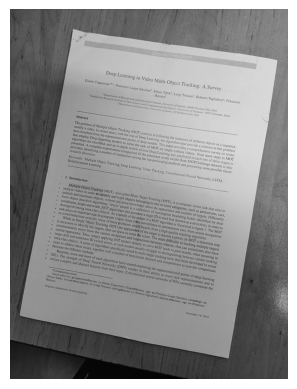

In [ ]:
grayscale = to_grayscale(image)
imshow(grayscale)

In [ ]:
grayscale.shape

(800, 600)

## Blurring the Image

The Gaussian filter or its more advanced sibling, the Bilateral filter, have shown the best results. Go with whatever smoothing filter you prefer. Considering that the image is highly likely to contain texts, adjust your window size accordingly.

In [ ]:
def blur(image):
    gaussian_blur_image = cv2.GaussianBlur(image, (5, 5), 0)
    return gaussian_blur_image

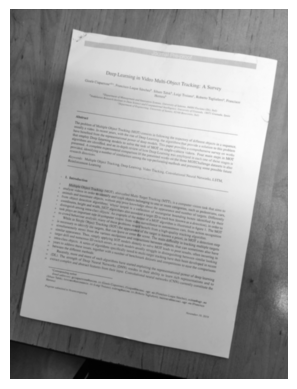

In [ ]:
blurred = blur(grayscale)
imshow(blurred)

## Edge Detection

The `cv2.Canny` filter tends to generate the best results. Tune its thresholds using the provided image and try it on a few more examples.

In [ ]:
def to_edges(image):
    edges = cv2.Canny(image, threshold1=150, threshold2=150)
    return edges

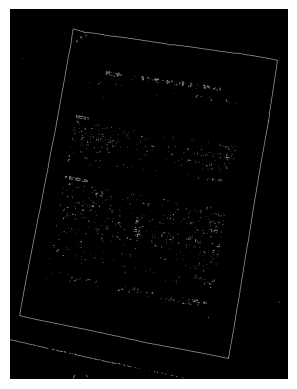

In [ ]:
edges = to_edges(blurred)
imshow(edges)

## Contour Detection

We highly suggest that you learn more about [image contours](https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html), specifically, the `cv2.findContours` function. You'd want to find the contour that has the largest surface area (using `cv2.contourArea`) and simplify its boundaries to a quadrilateral using `cv2.approxPolyDP` (and possibly `cv2.arcLength`). If this all sounds too complicated, go with the Hough transform. As discussed in the instructions, you can use the Hough transform to identify four lines within the output of `to_edges` to identify the most prominent parallelogram present in the image. This isn't, however, the best solution.

Regardless of the method, the output of the function must be the coordinates of the four vertices containing the page, in the form of a `4x2` array.

*Hint*: If you are using `cv2.findContours`, the Simple Approximation Model suffices for our purposes.

In [ ]:
def find_vertices(edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)

    if len(approx) == 4:
        vertices = approx.reshape(4, 2)
        return vertices
    else:
        raise ValueError("Could not approximate the contour to a quadrilateral.")

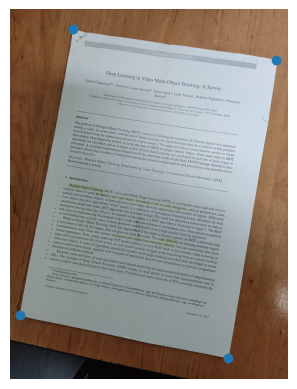

In [ ]:
imshow(image)
vertices = find_vertices(edges)
plt.scatter([x for x, y in vertices], [y for x, y in vertices])

## Perspective Transform

We can use the `cv2.getPerspectiveTransform` function to find a transform that maps the region we have identified to a rectangle that we can easily crop. You then need to use `cv2.warpPerspective` to apply this transform and crop out the target region.

**Note**: `cv2.getPerspectiveTransform` expects your vertices in a particular order. They should be top left, top right, bottom right, and finally, bottom left. We have implemented a utility function for this purpose.

In [ ]:
def order_vertices(vertices):
    vertices = vertices.reshape(4, 2)
    ordered = np.zeros((4, 2), dtype=np.float32)

    s = vertices.sum(axis=1)
    ordered[0] = vertices[np.argmin(s)]  # Top-left
    ordered[2] = vertices[np.argmax(s)]  # Bottom-right

    diff = np.diff(vertices, axis=1)
    ordered[1] = vertices[np.argmin(diff)]  # Top-right
    ordered[3] = vertices[np.argmax(diff)]  # Bottom-left

    return ordered

In [ ]:
def crop_out(im, vertices):
    vertices = order_vertices(vertices)

    width = 1200
    height = 1600
    target = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype=np.float32)

    transform = cv2.getPerspectiveTransform(vertices, target)
    cropped = cv2.warpPerspective(im, transform, (width, height))

    return cropped

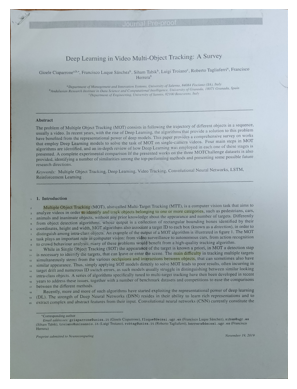

In [ ]:
cropped = crop_out(image, vertices)
imshow(cropped)

## Image Enhancement

I'll leave this part up to you!

In [ ]:
def enhance_before(image):
    smoothed = cv2.GaussianBlur(image, (3, 3), 0)

    sharpening_kernel = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])

    sharpened = cv2.filter2D(smoothed, -1, sharpening_kernel)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(sharpened)
    return enhanced

In [ ]:
def my_enhance(image, height_split=2, width_split=2, dark_percent=20, invert_output=True, darkness_threshold=130):
    height, width = image.shape
    height_len = height // height_split
    width_len = width // width_split

    result_image = np.full_like(image, 255 if invert_output else 0)
    histogram_dict = {}
    threshold_dict = {}

    for i in range(height_split):
        for j in range(width_split):
            y_start, y_end = i * height_len, (i + 1) * height_len
            x_start, x_end = j * width_len, (j + 1) * width_len
            patch = image[y_start:y_end, x_start:x_end]

            hist = cv2.calcHist([patch], [0], None, [256], [0, 256])
            histogram_dict[(i, j)] = hist

            cdf = np.cumsum(hist) / patch.size

            threshold_intensity = np.argmax(cdf >= dark_percent/100)
            threshold_dict[(i, j)] = threshold_intensity

            text_mask = (patch <= threshold_intensity) & (patch <= darkness_threshold)

            if invert_output:
                result_image[y_start:y_end, x_start:x_end][text_mask] = 0
            else:
                result_image[y_start:y_end, x_start:x_end][text_mask] = 255

    return result_image, histogram_dict, threshold_dict

In [ ]:
def enhance_after(image):
    smoothed = cv2.GaussianBlur(image, (9, 9), 0)
    sharpening_kernel = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])

    sharpened = cv2.filter2D(smoothed, -1, sharpening_kernel)
    return sharpened

## Result

Let's put everything together and get the result in one go.

In [ ]:
def scan(image):
    grayscale = to_grayscale(image)
    blurred = blur(grayscale)
    edges = to_edges(blurred)
    vertices = find_vertices(edges)
    cropped = crop_out(grayscale, vertices)
    return cropped

True

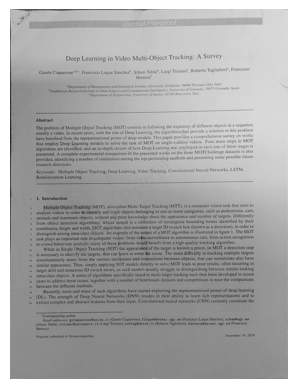

In [ ]:
scanned = scan(image)
imshow(scanned)
cv2.imwrite("scanned.jpeg", scanned)

True

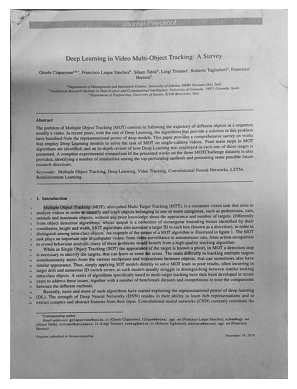

In [ ]:
enhanced_before = enhance_before(scanned)
imshow(enhanced_before)
cv2.imwrite("enhanced_before.jpeg", enhanced_before)

True

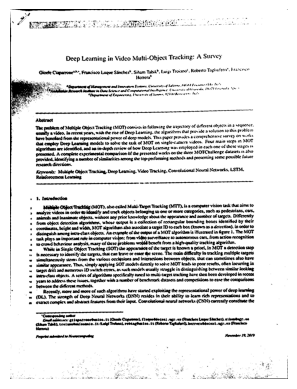

In [ ]:
enhanced, hist_dict, threshold = my_enhance(enhanced_before, 1, 1)
imshow(enhanced)
cv2.imwrite("enhanced.jpeg", enhanced)

True

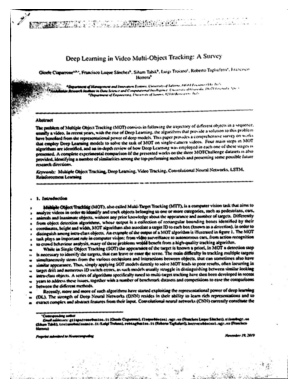

In [ ]:
enhanced_after = enhance_after(enhanced)
imshow(enhanced_after)

cv2.imwrite("enhanced_after.jpeg", enhanced_after)